# Directed functional/effective network inference with TE on Cellular Automata

In this activity we will perform pairwise functional and then effective network inference using MI and TE on our previous Cellular Automata data set, where we know the structure of the underlying network and have a good understanding of the dynamics.

## A. Functional network inference with MI

First we will infer the functional network to represent the pairwise statistical relationships between the cells as the nodes in our network.

1. Make sure you have a sample data set for CA rule 54 from our tutorial activities in the previous modules -- our to download again see the link on the tutorial website.
2. Now open the MI AutoAnalyser. Select a Discrete estimator, select your CA data file, tick the checkbox for `All pairs?` and -- most importantly -- untick the checkbox for `Compute result?` (we don't want to run this computation, it will take a lot of time!), and click `Generate Code`.
3. Paste the code into the code cells below.
4. Examine how the generated code is computing the MI for each cell pair.
5. Nake a few changes to the code here for our purposes:
    * Once we get to directed network inference, it will make more sense for our outer loop to be over targets, so that we consider the set of sources afterwards for that target. So, swap the order of the loops over `s` and `d` (so that the outer loop is over `d`)
    * We also don't want to compute the functional network over the whole 10000 cells - this will take too long and is too large to visualise. Let's just work with the first 100. So, before the loops make a new variable `networkSize=100;`
    * Then have the loops over `s` and `d` only run up to `networkSize` instead of all the way up to `10000`.
    * Create a 2D array to store the MI values before the for loops, `results = numpy.zeros((networkSize,networkSize));`
    * Remove the `print` statement, and instead assign the result to the results array, as `results[s,d] = result;`

In [1]:
# Paste import and JVM startup lines here:

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

In [2]:
# Paste analysis code here:

# 0. Load/prepare the data:
dataRaw = readIntsFile.readIntsFile("/home/joseph/TeachingPlayground/CSYS5030/Week10/ca54.txt")
# As numpy array:
data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
calc = calcClass(2, 2, 0)
# 2. No other properties to set for discrete calculators.

networkSize=100;
results = numpy.zeros((networkSize,networkSize));
# Compute for all pairs:
for d in range(networkSize):
    for s in range(networkSize):
        # For each source-dest pair:
        if (s == d):
            continue
        source = JArray(JInt, 1)(data[:, s].tolist())
        destination = JArray(JInt, 1)(data[:, d].tolist())

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.addObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()

        results[s,d] = result;

6. Run the above code cells, and then run the next code cell to plot the adjacency matrix of the functional network, as well as say the first 100 time steps of the CA dynamics so we can interpret what's happening:

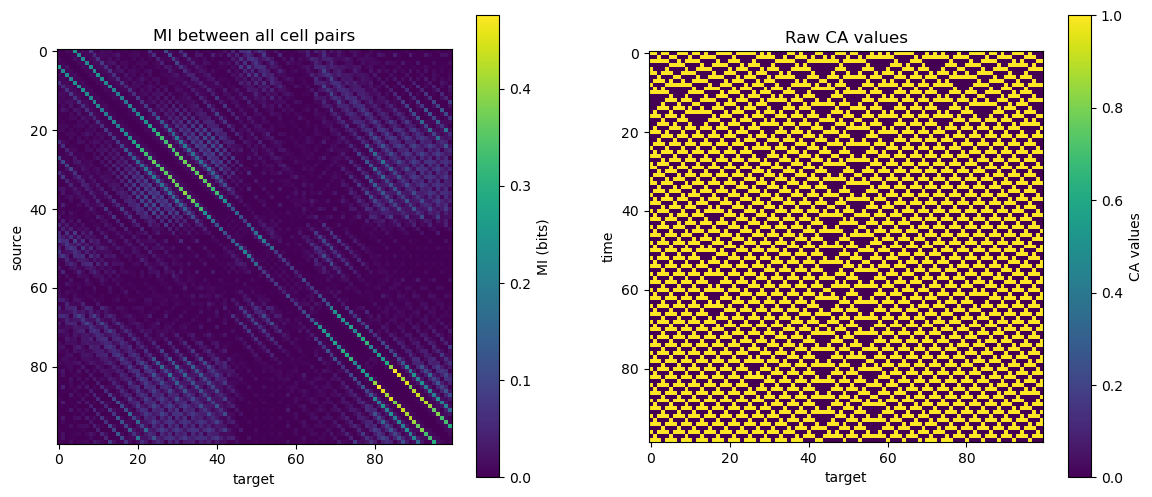

In [3]:
# Plot the functional connectivity
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.subplot(1,2,1) # left subplot
plt.imshow(results)
plt.xlabel('target');
plt.ylabel('source');
plt.title('MI between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('MI (bits)');
# Plot the first 100 time steps for the cells we're analysing:
plt.subplot(1,2,2) # right subplot
plt.imshow(data[:99,:networkSize]) # Plotting the first 100 time steps for first networkSize cells
plt.xlabel('target');
plt.ylabel('time');
plt.title('Raw CA values');
cbar = plt.colorbar()
cbar.set_label('CA values');

7. Look at the results for the adjacency matrix for the MI functional network in figure 1 (left):
    * What do you observe in terms of the functional network structure? Which sources have the highest MI to each target?
    * How does it compare to what you know the underlying causal structure to be? Is that what you expected to see?
    * Can you interpret the features of the network via the dynamics that you can see in figure 2 (right)? What generates the modular block structure?

## B. Directed functional network inference with TE

Now, we move on to infer a directed functional network with TE, to show the directed pairwise statistical relationships in the network.

1. Start by copying the above two code cells for the functional network with MI (and plots), and pasting it into the code cell below that we will edit for TE.
2. Open the TE AutoAnalyser - we're just going to generate some dummy code to grab a few lines from. Select a Discrete estimator, select your CA data file, tick the checkbox for `All pairs?`, set the `k_HISTORY` at 4 (we won't have enough data here for it to be larger, since we're assuming _heterogeneous_ variables here), and -- most importantly -- untick the checkbox for `Compute result?` (we don't want to run this computation, it will take a lot of time!), and click `Generate Code`.
3. Copy the lines constructing the TE calculator, and paste it into your Matlab script, replacing where the MI calculator was previously constructed.
4. Down the bottom of the code where the adjacency matrix is plotted, in the `title()` and `set_label()` functions replace "MI" with "TE".

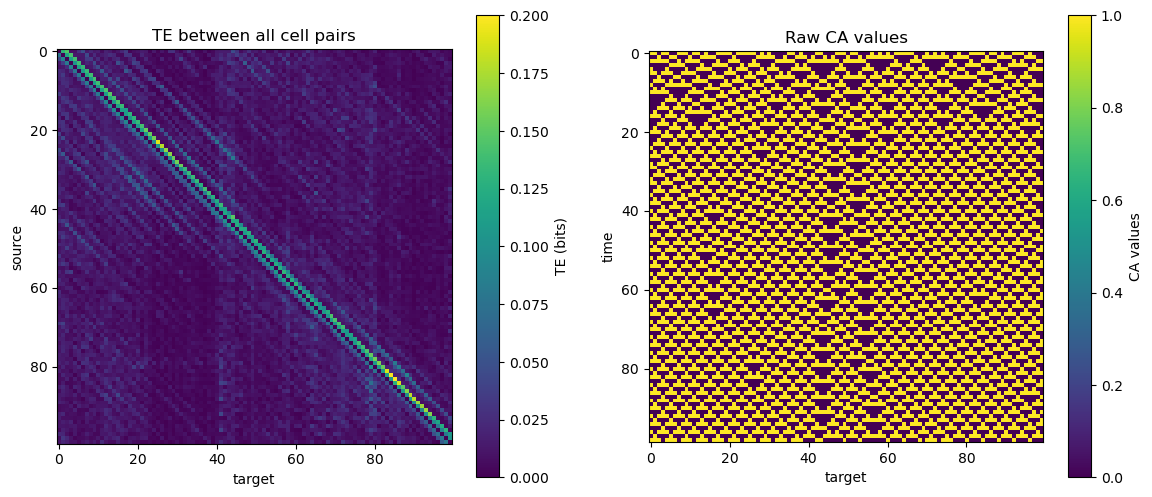

In [4]:
# Copy the MI analysis and plotting code cells into here; we will edit these to use TE

# Paste analysis code here:

# 0. Load/prepare the data:
dataRaw = readIntsFile.readIntsFile("/home/joseph/TeachingPlayground/CSYS5030/Week10/ca54.txt")
# As numpy array:
data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
calc = calcClass(2, 4, 1, 1, 1, 1)
# 2. No other properties to set for discrete calculators.

networkSize=100;
results = numpy.zeros((networkSize,networkSize));
pValues = numpy.zeros((networkSize,networkSize));
# Compute for all pairs:
for d in range(networkSize):
    for s in range(networkSize):
        # For each source-dest pair:
        if (s == d):
            pValues[s,d] = 1;
            continue
        source = JArray(JInt, 1)(data[:, s].tolist())
        destination = JArray(JInt, 1)(data[:, d].tolist())

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.addObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()
        # 6. Compute the (statistical significance via) null distribution analytically:
        measDist = calc.computeSignificance()

        results[s,d] = result;
        pValues[s,d] = measDist.pValue;

# Plot the functional connectivity
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.subplot(1,2,1) # left subplot
plt.imshow(results)
plt.xlabel('target');
plt.ylabel('source');
plt.title('TE between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('TE (bits)');
# Plot the first 100 time steps for the cells we're analysing:
plt.subplot(1,2,2) # right subplot
plt.imshow(data[:99,:networkSize]) # Plotting the first 100 time steps for first networkSize cells
plt.xlabel('target');
plt.ylabel('time');
plt.title('Raw CA values');
cbar = plt.colorbar()
cbar.set_label('CA values');

5. Run the script, and observe the results for the adjacency matrix for the TE directed functional network in the figure:
    * Compare the results to those for the MI functional network. Has the location of the strongest sources for each target changed? Is this what you expected? Is this beginning to inform us of a more sensible model of the dynamics for each target, given who we know the sources for each target are?
    * Do you still observe a modular block structure? How might we explain this with reference to the dynamics of the CA and the TE measure?
    * Could you select a reasonable threshold to select parent cells for each target cell here? Try replotting the TE results but thresholding for parent selection via, e.g. `plt.imshow(results > 0.1);` for a threshold at 0.1 bits, to see if you can identify a threshold that works well everywhere.


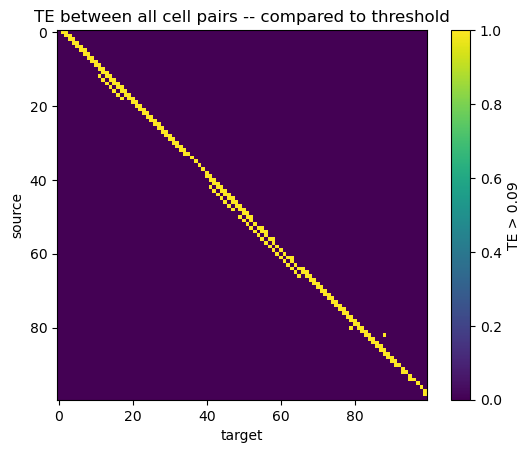

In [5]:
# Try replotting the TE results with a threshold for parent selection

threshold = 0.09
plt.figure()
plt.imshow(results > threshold)
plt.xlabel('target');
plt.ylabel('source');
plt.title('TE between all cell pairs -- compared to threshold');
cbar = plt.colorbar()
cbar.set_label('TE > %.2f' % threshold);

7. Let's look into making a more principled threshold selection, following methods described in the lectures. We will add some code to the cell above to compute the p-values for the TE estimates from each source, analytically:
    * Go back to the AutoAnalyser, ticking the checkboxes for `Add stat. signif.?` and `analytically?` to generate some template code of how to do this.
    * Copy and paste the calculation of the `measDist` object after the TE calculation, and then store its member value `measDist.pValue` into a 2D array `pValues` as we have already done for `results`. Recall - what is the meaning of the p-value result for a given source?
    * Where the if statement checks `if (s == d):` set `pValues[s,d] = 1;` otherwise seeing a 0 value there may confuse us.
8. Re-run the above TE calculations, and also run the following code cell to plot the p-values.<br/>
Take a look at the new figure below plotting the p-values. We will need to zoom in to see which sources have significant p-values here. We'll zoom in to only see sources which pass a Bonferroni corrected threshold `0.05 / (networkSize * (networkSize-1))` (to correct for the multiple comparisons here): uncomment the last line in the next code cell which now zooms in for us, and re-run this code cell.<br/>
Any p-value that is below the extreme maximal colour would pass a statistical test here and be inferred as a parent in the directed functional network.

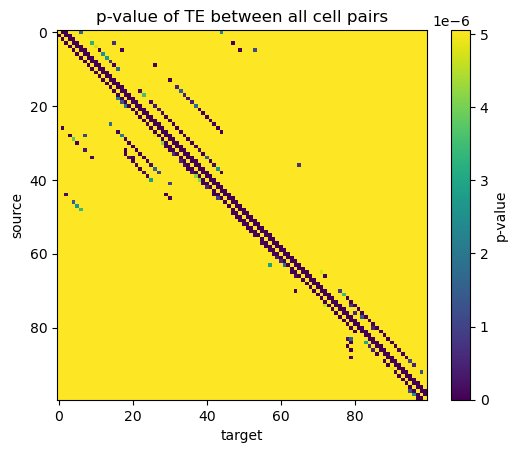

In [6]:
# Plot the p-values for each pairwise calculation:
plt.figure()
plt.imshow(pValues)
plt.xlabel('target');
plt.ylabel('source');
plt.title('p-value of TE between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('p-value');
plt.clim(0,0.05/(networkSize*(networkSize-1))); # Can use this to highlight significant p-values

8. Compared to the MI functional network and thresholding the TE value, these directed functional networks capture the direct parents on either side of the target, and we've addressed the issue of a more principled threshold selection. Still, are there many sources which appear to be parents here that you would not expect, given that we know only one source on either side of the target cell are its direct parents? Think about how we could extend the standard algorithm to exclude those other sources from being selected? (This is the subject of the next parts of the lecture)

<hr/>

## C. Effective network inference with multivariate TE

I've put together demonstration code to show a rudimentary implementation of the effective network inference on the CA data in the code cell below.

1. Inspect the code, comparing it to the pairwise TE directed functional network code that we produced in the previous activity. Try to understand the main features:
    * Inside the loop over targets, where we infer the set of parents for each, we have an additional while loop over rounds of adding parents to the set.
    * Within each round, we have a loop over the candidate sources.
    * Each candidate source is evaluated using a conditional TE, conditioning on previously selected parents.
    * After all candidates are evaluated, we identify the candidate with the strongest conditional TE, and check the statistical significance of this value.
    * If the source is statistically significant, we continue to another round to try to select another parent. Else we stop for this target.
2. Try to run the code, and compare the results to your expectations for a good multivariate model explaining the dynamics, as well as to the functional networks from MI and pairwise TE above.
    * Think through why the inference method might still not completely match the underlying structure, including: statistical fluctuations from the short data set effecting who the strongest sources are, and statistical power, hard coded history length used which may leave more information in spurious sources, no use of pruning step here, conservative p-value threshold and use of analytic surrogates.

Beginning greedy selection of parents for 0
Selected source 1, with TE(1->0 | )=0.07791, p-value=0.00000 (conditioning on 0 parents)
-- Max TE source 26 was not significant (TE(26->0 | 1)=0.05884, p-value=0.000114), quitting
Beginning greedy selection of parents for 1
Selected source 0, with TE(0->1 | )=0.13104, p-value=0.00000 (conditioning on 0 parents)
Selected source 2, with TE(2->1 | 0)=0.22481, p-value=0.00000 (conditioning on 1 parents)
-- Max TE source 0 was not significant (TE(0->1 | 0,2)=0.00000, p-value=1.000000), quitting
Beginning greedy selection of parents for 2
Selected source 0, with TE(0->2 | )=0.14630, p-value=0.00000 (conditioning on 0 parents)
Selected source 3, with TE(3->2 | 0)=0.09115, p-value=0.00000 (conditioning on 1 parents)
-- Max TE source 1 was not significant (TE(1->2 | 0,3)=0.10124, p-value=0.000024), quitting
Beginning greedy selection of parents for 3
Selected source 1, with TE(1->3 | )=0.14275, p-value=0.00000 (conditioning on 0 parents)
Selected sou

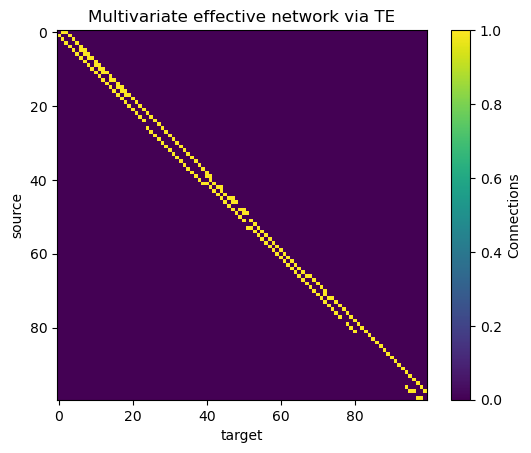

In [7]:
network = numpy.zeros((networkSize,networkSize), dtype=int);
# Compute for all targets:
for d in range(networkSize):

    print('Beginning greedy selection of parents for %d' % d);

    destination = JArray(JInt, 1)(data[:, d].tolist())
    conditionalSet = [];

    while (True):
        # Precondition: we have already selected the parents in
        #  conditionalSet, now we check if we can add to this:
        
        results = numpy.zeros((networkSize));
        pValues = numpy.zeros((networkSize));

        # 1. Construct the calculator:
        if (len(conditionalSet) > 0):
            calcClass = JPackage("infodynamics.measures.discrete").ConditionalTransferEntropyCalculatorDiscrete
            calc = calcClass(2, 4, len(conditionalSet))
        else:
            calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
            calc = calcClass(2, 4, 1, 1, 1, 1)
        # 2. No other properties to set for discrete calculators.
        for s in range(networkSize):
            # For each source-dest pair:
            
            if ( (s == d) or (s in conditionalSet) ):
                # If s is the target, or already in the conditioning set, skip evaluating TE from it
                pValues[s] = 1;
                continue
            source = JArray(JInt, 1)(data[:, s].tolist())
            conditional = JArray(JInt, 2)(data[:, conditionalSet].tolist())

            # 3. Initialise the calculator for (re-)use:
            calc.initialise()
            # 4. Supply the sample data:
            if (len(conditionalSet) > 0):
                calc.addObservations(source, destination, conditional)
            else:
                calc.addObservations(source, destination)

            # 5. Compute the estimate:
            result = calc.computeAverageLocalOfObservations()
            # 6. Compute the (statistical significance via) null distribution analytically:
            measDist = calc.computeSignificance()

            results[s] = result;
            pValues[s] = measDist.pValue;

        # Check which was the strongest source:
        maxSourceIndex = numpy.argmax(results);
        maxTE = results[maxSourceIndex];
        if (pValues[maxSourceIndex] < 0.05/(networkSize*(networkSize-1))):
            print('Selected source %d, with TE(%d->%d | %s)=%.5f, p-value=%.5f (conditioning on %d parents)' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, \
                pValues[maxSourceIndex], len(conditionalSet) ));
            # Add this new source:
            conditionalSet.append(maxSourceIndex);
        else:
            print('-- Max TE source %d was not significant (TE(%d->%d | %s)=%.5f, p-value=%.6f), quitting' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, pValues[maxSourceIndex]));
            break
    
    # Postcondition: conditionalSet holds the parents for target d
    network[conditionalSet, d] = 1;

# Plot the effective connectivity
plt.figure()
plt.imshow(network)
plt.xlabel('target');
plt.ylabel('source');
plt.title('Multivariate effective network via TE');
cbar = plt.colorbar()
cbar.set_label('Connections');

A sample results plot is shown on the tutorial website (yours will not match precisely due to stochastic generation of the dynamics but should have similar features).

3. _Optional extension -- advanced_: Can you incorporate code to address any of those issues to improve the network inference here?

Beginning greedy selection of parents for 0
Optimal k=5, giving bias corrected AIS(k=5)=0.6612 bits
-- Max TE source 1 was not significant (TE(1->0 | )=0.06158, p-value=0.000044), quitting
Beginning greedy selection of parents for 1
Optimal k=5, giving bias corrected AIS(k=5)=0.6709 bits
Selected source 0, with TE(0->1 | )=0.12902, p-value=0.00000 (conditioning on 0 parents)
Selected source 2, with TE(2->1 | 0)=0.17369, p-value=0.00000 (conditioning on 1 parents)
-- Max TE source 0 was not significant (TE(0->1 | 0,2)=0.00000, p-value=1.000000), quitting
Beginning greedy selection of parents for 2
Optimal k=6, giving bias corrected AIS(k=6)=0.6537 bits
Selected source 0, with TE(0->2 | )=0.14858, p-value=0.00000 (conditioning on 0 parents)
-- Max TE source 3 was not significant (TE(3->2 | 0)=0.06173, p-value=0.999973), quitting
Beginning greedy selection of parents for 3
Optimal k=5, giving bias corrected AIS(k=5)=0.6667 bits
Selected source 1, with TE(1->3 | )=0.14497, p-value=0.00000 

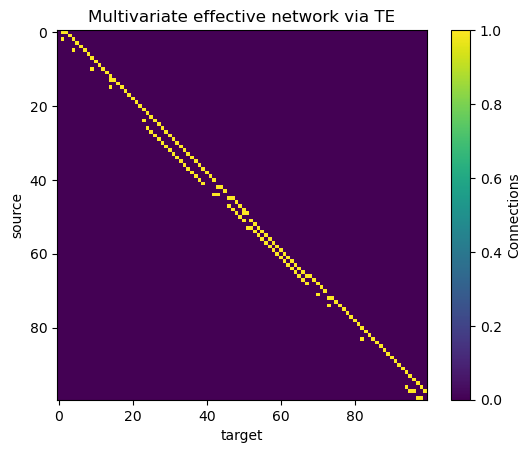

In [8]:
# Copy the code from the cell above and adapt it here

network = numpy.zeros((networkSize,networkSize), dtype=int);
# Compute for all targets:
for d in range(networkSize):

    print('Beginning greedy selection of parents for %d' % d);

    destination = JArray(JInt, 1)(data[:, d].tolist())
    conditionalSet = [];

    #######################
    # Let's optimise the selection of the embedding length for the target, like we did for AIS in module 10:
    kMax = 20;
    biasCorrectedAisResults = numpy.zeros((kMax))
    for k in range(1,kMax+1):
        # 1. Construct the calculator:
        aisCalcClass = JPackage("infodynamics.measures.discrete").ActiveInformationCalculatorDiscrete
        aisCalc = aisCalcClass(2, k)
        # 2. No other properties to set for discrete calculators.
        # 3. Initialise the calculator for (re-)use:
        aisCalc.initialise()
        # 4. Supply the sample data:
        aisCalc.addObservations(destination)
        # 5. Compute the estimate:
        ais = aisCalc.computeAverageLocalOfObservations()
        # 6. Compute the (statistical significance via) null distribution analytically:
        measDistAis = aisCalc.computeSignificance()
        biasAis = measDistAis.getMeanOfDistribution()
        biasCorrectedAisResults[k-1] = ais - biasAis
    optimalK = numpy.argmax(biasCorrectedAisResults)+1 # Need to add 1 for the array offset
    print('Optimal k=%d, giving bias corrected AIS(k=%d)=%.4f bits' % (optimalK,optimalK,biasCorrectedAisResults[optimalK-1])) # subtract 1 for array indexing
    
    while (True):
        # Precondition: we have already selected the parents in
        #  conditionalSet, now we check if we can add to this:
        
        results = numpy.zeros((networkSize));
        pValues = numpy.zeros((networkSize));

        # 1. Construct the calculator:
        if (len(conditionalSet) > 0):
            calcClass = JPackage("infodynamics.measures.discrete").ConditionalTransferEntropyCalculatorDiscrete
            calc = calcClass(2, optimalK, len(conditionalSet))
        else:
            calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
            calc = calcClass(2, optimalK, 1, 1, 1, 1)
        # 2. No other properties to set for discrete calculators.
        for s in range(networkSize):
            # For each source-dest pair:
            
            if ( (s == d) or (s in conditionalSet) ):
                # If s is the target, or already in the conditioning set, skip evaluating TE from it
                pValues[s] = 1;
                continue
            source = JArray(JInt, 1)(data[:, s].tolist())
            conditional = JArray(JInt, 2)(data[:, conditionalSet].tolist())

            # 3. Initialise the calculator for (re-)use:
            calc.initialise()
            # 4. Supply the sample data:
            if (len(conditionalSet) > 0):
                calc.addObservations(source, destination, conditional)
            else:
                calc.addObservations(source, destination)

            # 5. Compute the estimate:
            result = calc.computeAverageLocalOfObservations()
            # 6. Compute the (statistical significance via) null distribution analytically:
            measDist = calc.computeSignificance()

            results[s] = result;
            pValues[s] = measDist.pValue;

        # Check which was the strongest source:
        maxSourceIndex = numpy.argmax(results);
        maxTE = results[maxSourceIndex];
        if (pValues[maxSourceIndex] < 0.05/(networkSize*(networkSize-1))):
            print('Selected source %d, with TE(%d->%d | %s)=%.5f, p-value=%.5f (conditioning on %d parents)' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, \
                pValues[maxSourceIndex], len(conditionalSet) ));
            # Add this new source:
            conditionalSet.append(maxSourceIndex);
        else:
            print('-- Max TE source %d was not significant (TE(%d->%d | %s)=%.5f, p-value=%.6f), quitting' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, pValues[maxSourceIndex]));
            break
    
    # Postcondition: conditionalSet holds the parents for target d
    network[conditionalSet, d] = 1;

# Plot the effective connectivity
plt.figure()
plt.imshow(network)
plt.xlabel('target');
plt.ylabel('source');
plt.title('Multivariate effective network via TE');
cbar = plt.colorbar()
cbar.set_label('Connections');